In [1]:
import xarray as xr
import xbitinfo as xb

In [2]:
!pip install cmocean -qU

In [3]:
# Load some useful modules 
import numpy as np
import xarray as xr
import xrft
from xmitgcm import llcreader
from matplotlib import pyplot as plt

import cmocean.cm as cm

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.path as mpath

#import xmovie
%matplotlib inline

In [4]:
from intake import open_catalog

cat = open_catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/llc4320.yaml")

In [5]:
# Get variables from catalog
sst = cat.LLC4320_SST.to_dask()
sss = cat.LLC4320_SSS.to_dask()
ssh = cat.LLC4320_SSH.to_dask()
u = cat.LLC4320_SSU.to_dask()
v = cat.LLC4320_SSV.to_dask()

In [6]:
coords = cat.LLC4320_grid.to_dask()

In [7]:
u.U.attrs = {'long_name': 'Zonal Velocity (m/s)', 
            'mate': 'V', 'units':'m/s'}
v.V.attrs = {'long_name': 'Meridional Velocity (m/s)', 
            'mate': 'U', 'units':'m/s'}

In [8]:
ds = xr.merge([ u, v, sst, ssh, sss.SSS, coords])

In [9]:
ds_ll = llcreader.llcmodel.faces_dataset_to_latlon(ds, 
                metric_vector_pairs=[])

In [10]:
ds_sel = ds_ll.isel(time=0)

In [11]:
ds_sel.nbytes/1e9

20.603773644

In [12]:
ds_sel.load()

<xarray.Dataset>
Dimensions:  (face: 13, i_g: 17280, j: 12960, i: 17280, j_g: 12960, k_p1: 2)
Coordinates: (12/37)
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i_g      (i_g) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
  * j        (j) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959
    time     datetime64[ns] 2011-09-13
  * i        (i) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
  * j_g      (j_g) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959
    ...       ...
    k_l      int64 1
    k_u      int64 1
    rA       (j, i) float32 1.555e+05 1.555e+05 ... 1.119e+04 6.303e+03
    rAs      (j_g, i) float32 7.774e+04 7.775e+04 ... 1.384e+04 8.727e+03
    rAw      (j, i_g) float32 1.555e+05 1.555e+05 ... 1.141e+04 5.677e+03
    rAz      (j_g, i_g) float32 7.774e+04 7.775e+04 ... 1.384e+04 8.727e+03
Data variables:
    SST      (j, i) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan
    Eta      (j, i) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan
    SSS      (j, i) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan
    U        (j, i_g) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    V        (j_g, i) float32 nan nan nan nan nan nan ... nan nan nan nan nan

In [13]:
import xgcm
grid = xgcm.Grid(ds_ll.drop(['k', 'k_p1']), periodic='X')

In [14]:
ds_sel['U'] = grid.interp(ds_sel['U'], 'X', boundary='periodic')

In [15]:
ds_sel['V'] = grid.interp(ds_sel['V'], 'Y', boundary='periodic')

In [16]:
ds_sel

<xarray.Dataset>
Dimensions:  (face: 13, i_g: 17280, j: 12960, i: 17280, j_g: 12960, k_p1: 2)
Coordinates: (12/37)
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i_g      (i_g) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
  * j        (j) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959
    time     datetime64[ns] 2011-09-13
  * i        (i) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
  * j_g      (j_g) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959
    ...       ...
    k_l      int64 1
    k_u      int64 1
    rA       (j, i) float32 1.555e+05 1.555e+05 ... 1.119e+04 6.303e+03
    rAs      (j_g, i) float32 7.774e+04 7.775e+04 ... 1.384e+04 8.727e+03
    rAw      (j, i_g) float32 1.555e+05 1.555e+05 ... 1.141e+04 5.677e+03
    rAz      (j_g, i_g) float32 7.774e+04 7.775e+04 ... 1.384e+04 8.727e+03
Data variables:
    SST      (j, i) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan
    Eta      (j, i) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan
    SSS      (j, i) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan
    U        (j, i) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan
    V        (j, i) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan

In [17]:
info_per_bit = xb.get_bitinformation(ds_sel, dim=['i','j'])

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [18]:
info_per_bit

<xarray.Dataset>
Dimensions:  (bit32: 32, dim: 2)
Coordinates:
  * bit32    (bit32) <U3 '±' 'e1' 'e2' 'e3' 'e4' ... 'm20' 'm21' 'm22' 'm23'
  * dim      (dim) <U1 'i' 'j'
Data variables:
    SST      (dim, bit32) float64 0.5117 0.973 0.0 ... 0.06219 0.06217 0.06222
    Eta      (dim, bit32) float64 0.8514 0.7106 0.0 ... 0.06218 0.06221 0.06217
    SSS      (dim, bit32) float64 0.0 0.9742 0.0 0.0 ... 0.06238 0.0623 0.06225
    U        (dim, bit32) float64 0.7449 0.02787 0.0 ... 0.06192 0.06164 0.01246
    V        (dim, bit32) float64 0.8555 0.02024 0.0 ... 0.06183 0.06149 0.01292
Attributes:
    xbitinfo_description:       bitinformation calculated by xbitinfo.get_bit...
    python_repository:          https://github.com/observingClouds/xbitinfo
    julia_repository:           https://github.com/milankl/BitInformation.jl
    reference_paper:            http://www.nature.com/articles/s43588-021-001...
    xbitinfo_version:           0.0.3
    BitInformation.jl_version:  0.6

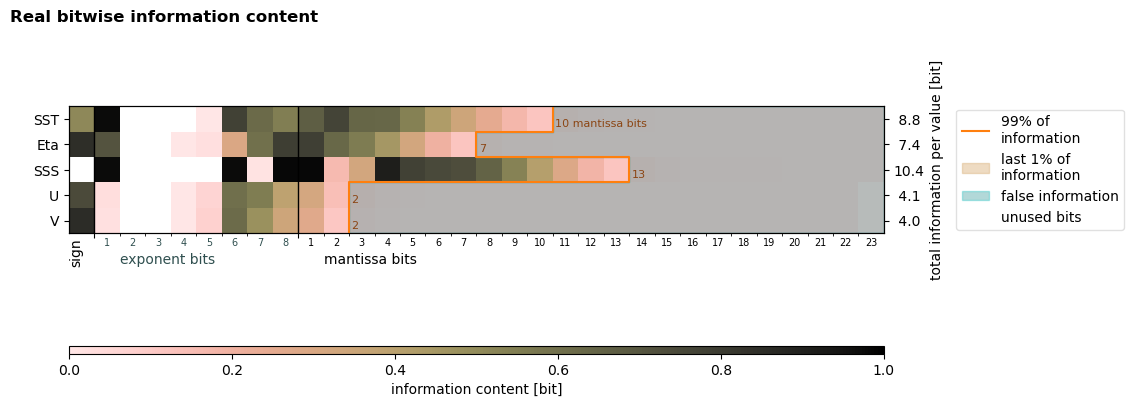

In [19]:
fig = xb.plot_bitinformation(info_per_bit.isel(dim=0))


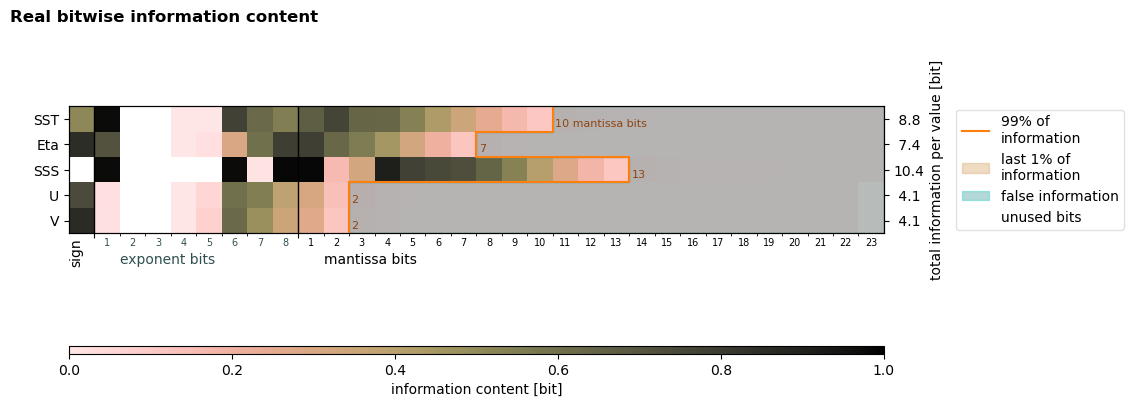

In [20]:
fig = xb.plot_bitinformation(info_per_bit.isel(dim=1))

In [100]:
keepbits = xb.get_keepbits(info_per_bit, 0.99999999)

In [101]:
keepbits

<xarray.Dataset>
Dimensions:   (dim: 2, inflevel: 1)
Coordinates:
  * dim       (dim) <U1 'i' 'j'
  * inflevel  (inflevel) float64 1.0
Data variables:
    SST       (dim, inflevel) int64 10 10
    Eta       (dim, inflevel) int64 7 7
    SSS       (dim, inflevel) int64 13 13
    U         (dim, inflevel) int64 2 2
    V         (dim, inflevel) int64 2 2

In [115]:
#ds_bitrounded = xb.xr_bitround(ds_sel, {'U': 7, 'V': 7, 'SST':15, 'SSS':15, 'Eta':12})
#ds_bitrounded = xb.xr_bitround(ds_sel, keepbits.max(dim='dim')+3)

keepbits_mod = keepbits.copy()
keepbits_mod['SSS'] = keepbits_mod['SSS'] + 2
keepbits_mod['Eta'] = keepbits_mod['Eta'] + 4
keepbits_mod['U'] = keepbits_mod['U'] + 4
keepbits_mod['V'] = keepbits_mod['V'] + 4

In [116]:
ds_bitrounded = xb.xr_bitround(ds_sel, keepbits_mod.max(dim='dim'))

In [117]:
len_reg = 500
temp = ds_sel.isel(i=slice(0, len_reg), j=slice(5000,5000+len_reg))
temp_bitrounded = ds_bitrounded.isel(i=slice(0, len_reg), j=slice(5000,5000+len_reg))

temp = temp.drop_vars(temp.coords)
temp_bitrounded = temp_bitrounded.drop_vars(temp_bitrounded.coords)

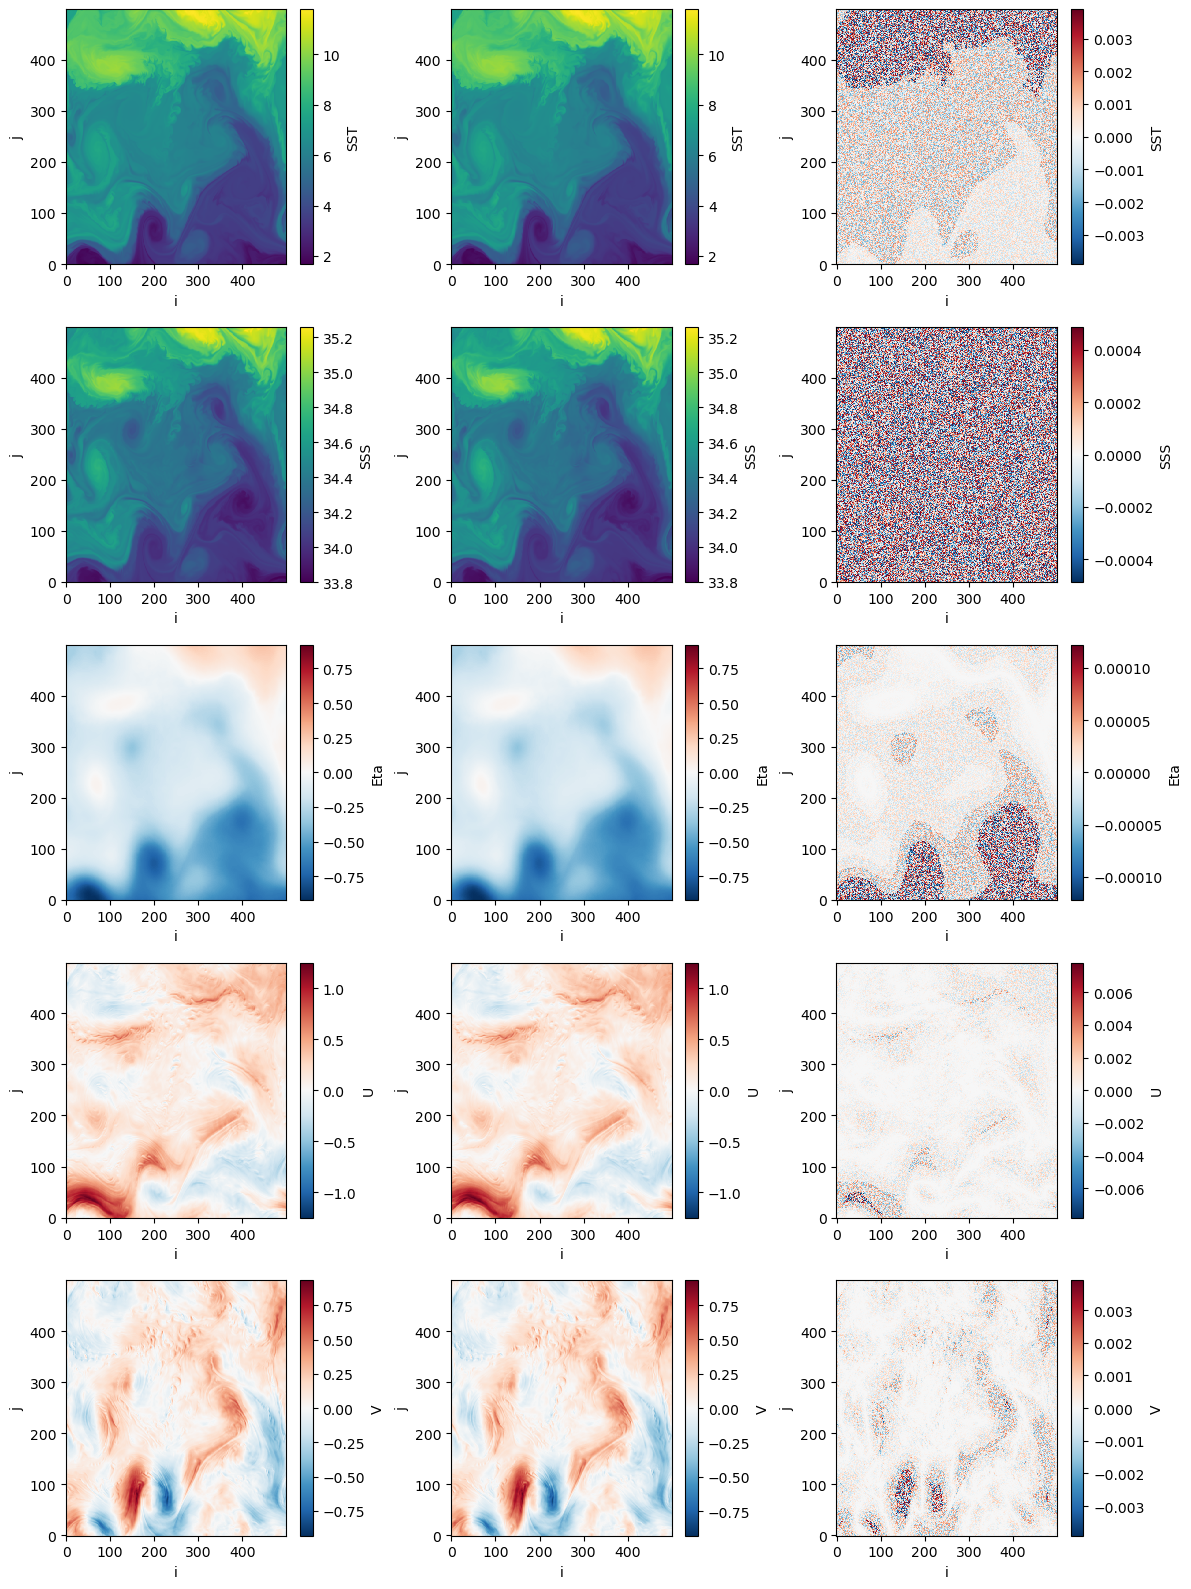

In [118]:
plt.figure(figsize=(12, 16))

var = 'SST'
n= 1
for i in ['SST', 'SSS', 'Eta', 'U', 'V']:
    
    plt.subplot(5, 3, n)
    temp[i].plot()
    n=n+1

    plt.subplot(5, 3, n)
    temp_bitrounded[i].plot()
    n=n+1
    
    plt.subplot(5, 3, n)
    (temp - temp_bitrounded)[i].plot()
    n=n+1
    
plt.tight_layout()

/srv/conda/envs/notebook/lib/python3.10/site-packages/xrft/xrft.py:47: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.10/site-packages/xrft/xrft.py:47: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.10/site-packages/xrft/xrft.py:47: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.10/site-packages/xrft/xrft.py:47: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.10/site-packages/xrft/xrft.py:47: FutureWarning

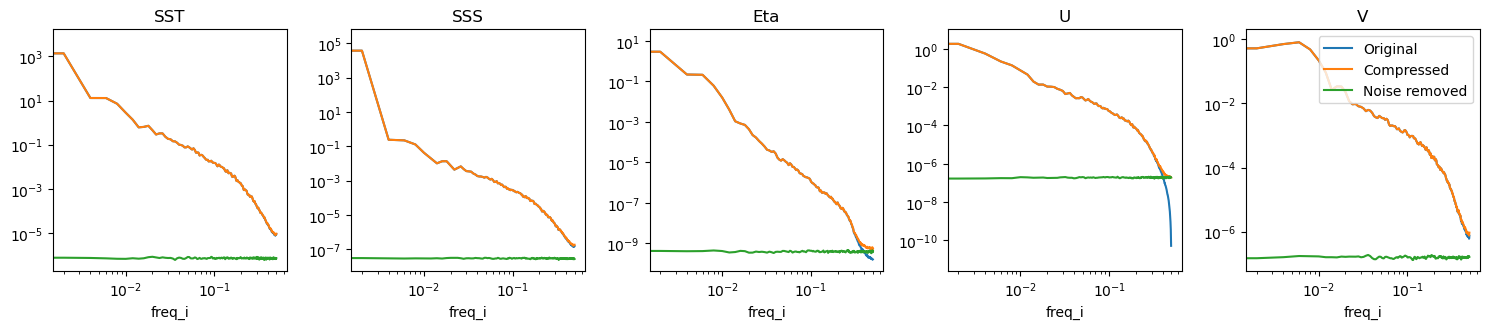

In [119]:
plt.figure(figsize = (15, 3.4))
n=1
for var in ['SST', 'SSS', 'Eta', 'U', 'V']: 
    temp_ps = xrft.power_spectrum(temp[var], 
                                  dim='i', window=True)
    temp_bitrounded_ps = xrft.power_spectrum(temp_bitrounded[var], 
                                  dim='i', window=True)
    
    temp_error_ps = xrft.power_spectrum(temp[var] - temp_bitrounded[var], 
                                  dim='i', window=True)
    
    plt.subplot(1,5,n)
    temp_ps.mean(['j']).plot(label='Original')

    temp_bitrounded_ps.mean(['j']).plot(label='Compressed')
   
    temp_error_ps.mean(['j']).plot(label='Noise removed')
    
    plt.xscale('log')
    plt.yscale('log')
    plt.title(var)
    
    
    n=n+1
plt.legend()
plt.tight_layout()

In [120]:
temp_bitrounded.to_compressed_netcdf("bitrounded_compressed.nc")
temp.to_compressed_netcdf("compressed.nc")
temp.to_netcdf("original.nc")

In [121]:
!du -hs *.nc

1.2M	bitrounded_compressed.nc
3.2M	compressed.nc
4.8M	original.nc


In [122]:
1.2/4.8

0.25

/srv/conda/envs/notebook/lib/python3.10/site-packages/xrft/xrft.py:47: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.10/site-packages/xrft/xrft.py:47: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(


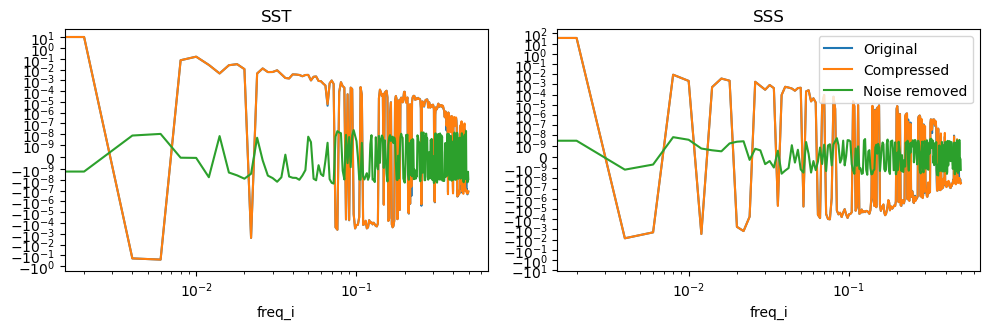

In [126]:
plt.figure(figsize = (10, 3.4))
n=1
vel_var = 'V'
for var in ['SST', 'SSS']: 
    temp_cs = xrft.cross_spectrum(temp[var], temp[vel_var],
                                  dim='i', window=True)

    temp_bitrounded_cs = xrft.cross_spectrum(temp_bitrounded[var], temp_bitrounded[vel_var],
                                  dim='i', window=True)
    
    temp_error_cs = xrft.cross_spectrum(temp[var] - temp_bitrounded[var], temp[vel_var] - temp_bitrounded[vel_var],
                                  dim='i', window=True)
    
    plt.subplot(1,2,n)
    np.real(temp_cs).mean(['j']).plot(label='Original')

    np.real(temp_bitrounded_cs).mean(['j']).plot(label='Compressed')
   
    np.real(temp_error_cs).mean(['j']).plot(label='Noise removed')
    
    plt.xscale('log')
    plt.yscale('symlog', linthresh=1e-9)
    plt.title(var)
    
    
    n=n+1
plt.legend()
plt.tight_layout()

/srv/conda/envs/notebook/lib/python3.10/site-packages/xrft/xrft.py:47: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.10/site-packages/xrft/xrft.py:47: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(


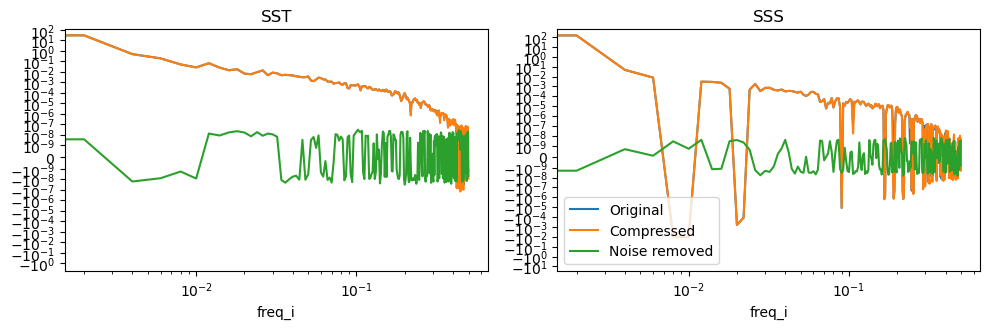

In [127]:
plt.figure(figsize = (10, 3.4))
n=1
vel_var = 'U'
for var in ['SST', 'SSS']: 
    temp_cs = xrft.cross_spectrum(temp[var], temp[vel_var],
                                  dim='i', window=True)

    temp_bitrounded_cs = xrft.cross_spectrum(temp_bitrounded[var], temp_bitrounded[vel_var],
                                  dim='i', window=True)
    
    temp_error_cs = xrft.cross_spectrum(temp[var] - temp_bitrounded[var], temp[vel_var] - temp_bitrounded[vel_var],
                                  dim='i', window=True)
    
    plt.subplot(1,2,n)
    np.real(temp_cs).mean(['j']).plot(label='Original')

    np.real(temp_bitrounded_cs).mean(['j']).plot(label='Compressed')
   
    np.real(temp_error_cs).mean(['j']).plot(label='Noise removed')
    
    plt.xscale('log')
    plt.yscale('symlog', linthresh=1e-9)
    plt.title(var)
    
    
    n=n+1
plt.legend()
plt.tight_layout()